In [1]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

#
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 
from sklearn.metrics import classification_report, confusion_matrix

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in the turnout data
turnout = pd.read_csv("../turnout.csv")

### First, I will split my data into training and test subsets.

In [3]:
# Train-Test split (just using Pandas)
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

In [4]:
# test to make sure they are split correctly
train.shape[0], test.shape[0]

(1600, 400)

In [5]:
# rename columns and drop id column
cols = train.columns.tolist()
new_cols = ['vote','age', 'educate', 'income','white']

# rearrange and set new columns
train = train[new_cols]
test = test[new_cols]

In [6]:
train.head()

,vote,age,educate,income,white
0,1,74,4.0,1.3257,1
1,1,42,12.0,8.7220,1
2,1,47,16.0,6.7838,1
3,1,44,12.0,8.7220,1
4,1,56,17.0,11.3918,1


### Then, I build the Bayesian classifier for continuous predictors. 

$$Pr(class | data) = Pr( x_1| class)\times Pr( x_2| class) \times \dots \times  Pr(class)$$

There are two potential outcomes, or classes: Vote == 0 and Vote == 1. Below are the probabilities of each.

In [7]:
# get total number of training observations
N = train.shape[0]

# subset data by class a.k.a. whether someone voted
vt1 = train.query("vote == 1")
vt0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vt1 = vt1.shape[0]/N
pr_vt0 = vt0.shape[0]/N

# Print the overall probabilities of each class 
print(
f"""
Pr(vote = 1): {pr_vt1}
Pr(vote = 0): {pr_vt0}
""")


Pr(vote = 1): 0.74875
Pr(vote = 0): 0.25125



In [8]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':vt1.age.mean(),'sd':vt1.age.std()},
 ("age",0):{'mean':vt0.age.mean(),'sd':vt0.age.std()},
 ("educate",1):{'mean':vt1.educate.mean(),'sd':vt1.educate.std()},
 ("educate",0):{'mean':vt0.educate.mean(),'sd':vt0.educate.std()},
 ("income",1):{'mean':vt1.income.mean(),'sd':vt1.income.std()},
 ("income",0):{'mean':vt0.income.mean(),'sd':vt0.income.std()},
 ("white",1):{'mean':vt1.white.mean(),'sd':vt1.white.std()},
 ("white",0):{'mean':vt0.white.mean(),'sd':vt0.white.std()},
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.72139303482587, 'sd': 19.070991930592108},
 ('age', 1): {'mean': 45.99415692821369, 'sd': 16.948665899459737},
 ('educate', 0): {'mean': 10.54726368159204, 'sd': 3.3038562785555605},
 ('educate', 1): {'mean': 12.492070116861436, 'sd': 3.2450945777905518},
 ('income', 0): {'mean': 2.854818159203981, 'sd': 2.323745483741833},
 ('income', 1): {'mean': 4.264254340567612, 'sd': 2.9060434653982696},
 ('white', 0): {'mean': 0.7686567164179104, 'sd': 0.4222167914941512},
 ('white', 1): {'mean': 0.8731218697829716, 'sd': 0.3329754020721955}}


Basically, the first entry in this dictionary reads: the average age for non-voters in our data was 42, with a standard deviation of 19 years. Below, we will visualize the conditional distributions based on these predictor variable subsets.

In [9]:
# Plot with seaborn
#plt.figure(figsize=(10,4),dpi=150)
#for key in dist_locs.keys():
#    locs = dist_locs[key]
#    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)]
#                     for i in np.linspace(-3,40)])
#    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")

### Now, let's try predicting some values with our Naive Bayes classifier and see how accurate our model is.

First, we will look at how this works with a single observation: the first row in our training data.

In [10]:
# this is the single observation we will try to predict
vote,age,educate,income,white = train.iloc[1,:]
print(vote,age,educate,income,white)

1.0 42.0 12.0 8.722000000000001 1.0


I need to add in the other predictors and make white a binary variable.

In [11]:
# Prediction for the vote class - need to add other predictors 
a = st.norm(dist_locs[("age",1)]['mean'], dist_locs[("age",1)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",1)]['mean'], dist_locs[("educate",1)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",1)]['mean'], dist_locs[("income",1)]['sd']).pdf(income)
d = st.norm(dist_locs[("white",1)]['mean'], dist_locs[("white",1)]['sd']).pdf(white)
e = pr_vt1

# this is the same we did before, multiply all the classes together
pr_1 = a * b * c * d * e

# Prediction for the did not vote class 
a = st.norm(dist_locs[("age",0)]['mean'], dist_locs[("age",0)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",0)]['mean'], dist_locs[("educate",0)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",0)]['mean'], dist_locs[("income",0)]['sd']).pdf(income)
d = st.norm(dist_locs[("white",0)]['mean'], dist_locs[("white",0)]['sd']).pdf(white)
e = pr_vt0

pr_0 = a * b * c * d * e

print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 9.825762147603859e-05
    Pr(y == 0| X): 3.317578252411109e-06



Since the probability of voting for these variables is larger than the probability of not voting, we predict that the person voted (and in fact they did). We want to do this same process for many other indiviudals in our data, so we make it a function below.

In [12]:
def predict(data,dist_locs):
    ''''''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1 # Use 1 here so it doesn't default to 0 upon multiplication 
        for j in range(1,len(row)):
            # this loop will take the conditional probability for each variable in the given row 
            # and multiply them to create our final probability for that class|data
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_vt0
        pr_1 *= pr_vt1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train,dist_locs)

In [13]:
# calculate the predictive accuracy on training data
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.7325

In [14]:
# calculate predictive accuracy on test data
preds_test = predict(test,dist_locs)
accuracy_test = sum(test.vote == preds_test.pred)/test.shape[0]
accuracy_test

0.7025

Our predictive accuracy on our training data with this simple classifier is about 73% and on our test data it is about 71%.

### We can compare our method to the one in Sklearn.

In [16]:
# Organize our data real quick so it plugs into the sklearn API easily 
train_y = train['vote']
train_x = train[['age','educate','income','white']]
test_y = test['vote']
test_x = test[['age','educate','income','white']]

In [17]:
# Instantiate the model class using Gaussian for continuous variables 
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7025

It's the same! Quick note: I may be able to get more accurate results by classifying white as a binary predictor in the future.

In [18]:
# Generate a confusion matrix of how our predictions turned out
pd.DataFrame(confusion_matrix(test_y, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

,Predicted Negative,Predicted Positive
Actual Negative,25,95
Actual Positive,24,256


### To take a look at our performance visually, we generate a ROC (Receiver Operating Characteristic) curve.

In [19]:
# make breakdown of probabilities for either class
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.465028,0.534972
1,0.088505,0.911495
2,0.242673,0.757327
3,0.225165,0.774835
4,0.040214,0.959786
...,...,...
395,0.146078,0.853922
396,0.240733,0.759267
397,0.023556,0.976444
398,0.389778,0.610222


In [20]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

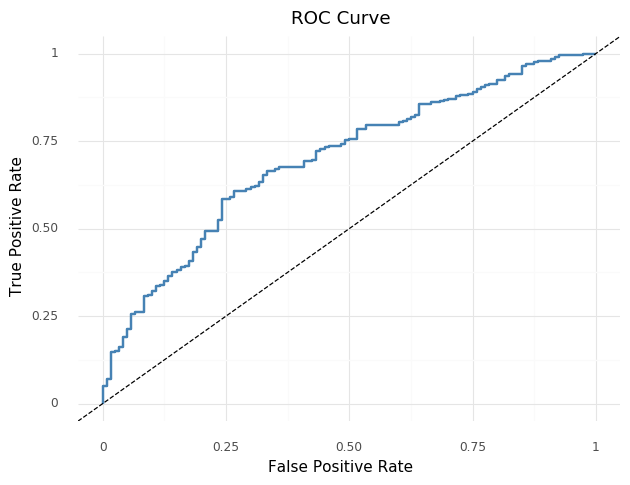

<ggplot: (8770677331505)>

In [21]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme(figure_size=(7,5))
)

In [22]:
# calculate the ROC auc score, which runs from 0 to 1 
m.roc_auc_score(test_y,y_pred)

0.5613095238095238

This ROC curve looks pretty flat, indicating that it is not the best at distinguishing between the positive and negative classes in our test data. Our area under the curve of 56.5% is *slightly* better than coin flip odds of 50%.

## Discussion

As we can see, our construction of the Naive Bayes classifier yielded the same accuracy as the Sklearn implementation. The accuracy of our model was about 71%, but the AUC was 57%, indicating that our model only performs slightly better than a coin flip. The ROC curve tells us how well our model separates our classes of voting and not voting, and it is lower than our accuracy because we classified the classes based on probabilities seen in the training data but that doesn't necessarily reflect the actual breakdown of these classes in real life. It doesn't make much of a difference to use the white variable as a continuous variable here, but in the future, I will include it as a binary one. 